In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python.retinotopy import utils as retutils
from pipeline.python.retinotopy import segment_retinotopy as seg

from pipeline.python import utils as putils

from matplotlib.lines import Line2D
import matplotlib.patches as patches

from pipeline.python.classifications import decode_utils as dutils
from pipeline.python.classifications import decode_by_ncells as dc
from pipeline.python.classifications import decode_utils as decutils

%matplotlib notebook

In [301]:
responsive_test='ROC'
responsive_thr=10. if responsive_test=='nstds' else 0.05
experiment='blobs'
response_type='df'

traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
stats_dir = os.path.join(aggregate_dir, 'data-stats')

In [302]:
# Set colors
visual_areas, area_colors = putils.set_threecolor_palette(soft=True)
dpi = putils.set_plot_params()

#### Responsive params
n_stds = None if responsive_test=='ROC' else 2.5 #None
response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 


In [303]:
# Get all data sets
visual_areas = ['V1', 'Lm', 'Li']
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
sdata['visual_area'].unique()

Segmentation: missing 9 dsets


array([u'Li', u'Ll', u'Lm', u'V1'], dtype=object)

In [313]:
print("............................................")
print("Responsive test: %s (thr=%.2f)" % (responsive_test, responsive_thr))
print("............................................")

curr_visual_area=None #'V1'
curr_datakey = None# '20190617_JC097_fov1'

#### Load neural responses
analysis_type='by_fov'
trial_epoch='baseline'
stack_neuraldf = False

#### Check for equal trial counts
_, all_cells, MEANS, SDF = aggr.get_source_data(experiment,
                        equalize_now=False, zscore_now=True,
                        response_type=response_type, responsive_test=responsive_test,
                        responsive_thr=responsive_thr, trial_epoch=trial_epoch,
                        visual_area=curr_visual_area, datakey=curr_datakey,
                        check_configs=True, return_configs=True, return_missing=False,
                        images_only=False)

all_cells = all_cells[all_cells['visual_area'].isin(visual_areas)]
all_cells.groupby(['visual_area']).count()

............................................
Responsive test: ROC (thr=0.05)
............................................
Segmentation: missing 9 dsets
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_ROC-thr-0.05_df_baseline.pkl
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [-15   0], y: [-5  0]
(skipping 20190314_JC070_fov1)
Segmentation: missing 9 dsets
SDF, images_only=False (excluding dsetes: [])


,cell,fov,animalid,session,datakey,fovnum,global_ix
visual_area,,,,,,,
Li,584,584,584,584,584,584,584
Lm,1127,1127,1127,1127,1127,1127,1127
V1,1251,1251,1251,1251,1251,1251,1251


In [314]:
overlap_thr=None
has_retino=False
threshold_dff=False
threshold_snr=False
match_distns = False
remove_too_few=False
min_ncells=5

stack_neuraldf = True
NDATA, CELLS = dc.get_cells_and_data(all_cells, MEANS, traceid=traceid, response_type=response_type, 
                stack_neuraldf=True, overlap_thr=overlap_thr, has_retino=has_retino, 
                threshold_snr=threshold_snr, remove_too_few=remove_too_few, min_ncells=min_ncells,
                threshold_dff=threshold_dff) 
                                
print("------------------------------------")
print("Final cell counts:")
CELLS[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()

cell_counts = dict(CELLS.groupby(['visual_area'])['cell'].count())

print("@@@@@@@@ cell counts @@@@@@@@@@@")
print(cell_counts)

~~~~~~~~~~~~~~~~No Receptive Fields~~~~~~~~~~~~~~~~~~~~~~~~~
Assigned visual areas: [u'Li' u'Lm' u'V1']
@@@@@@@@ cell counts @@@@@@@@@@@
{u'V1': 1251, u'Lm': 1127, u'Li': 584}
------------------------------------
------------------------------------
Final cell counts:
@@@@@@@@ cell counts @@@@@@@@@@@
{u'V1': 1251, u'Lm': 1127, u'Li': 584}


In [315]:
NDATA['response'] = NDATA['response']-NDATA['response'].min()

In [316]:
NDATA['response'].min()

0.0

In [317]:
t_=[]
for (visual_area, datakey), x0 in NDATA.groupby(['visual_area', 'datakey']):

    sdf = SDF[datakey].copy()
    ndf = x0.copy()
#     ndf['response']  = ndf['response'].subtract(ndf['response'].min())
    
#     x1 = aggr.stacked_neuraldf_to_unstacked(x0)
#     rois_ = [r for r in x1.columns if putils.isnumber(r)]
#     x2 = x1[rois_].subtract(x1[rois_].min(axis=0))
#     x2['config'] = x1['config']
#     x2['trial'] = x2.index.tolist()
#     ndf = pd.melt(x2, id_vars=['config', 'trial'], var_name='cell', value_name='response')

    sz_df = pd.concat([pd.Series(ndf[ndf.config.isin(sg.index.tolist())].groupby(['cell']).mean()['response'], name=sz)\
                for sz, sg in sdf[sdf.morphlevel!=-1].groupby(['size'])], axis=1)

    mp_df = pd.concat([pd.Series(ndf[ndf.config.isin(sg.index.tolist())].groupby(['cell']).mean()['response'], name=sz)\
                for sz, sg in sdf[sdf.morphlevel!=-1].groupby(['morphlevel'])], axis=1)

    sz1 = sz_df.divide(sz_df.sum(axis=1), axis=0)
    mp1 = mp_df.divide(mp_df.sum(axis=1), axis=0)

    stds_sz = pd.DataFrame(sz1.std(axis=1), columns=['std'])
    stds_sz['condition'] = 'size'

    stds_mp = pd.DataFrame(mp1.std(axis=1), columns=['std'])
    stds_mp['condition'] = 'morphlevel'

    tmpdf = pd.concat([stds_sz, stds_mp], axis=0)
    tmpdf['cell'] = tmpdf.index.tolist()
    tmpdf['visual_area'] = visual_area
    tmpdf['datakey']=datakey
    
    t_.append(tmpdf)

In [318]:
df = pd.concat(t_, axis=0)
df.head()

,std,condition,cell,visual_area,datakey
cell,,,,,
174,0.001799,size,174,Li,20190314_JC070_fov1
175,0.000917,size,175,Li,20190314_JC070_fov1
177,0.001460,size,177,Li,20190314_JC070_fov1
219,0.000942,size,219,Li,20190314_JC070_fov1
220,0.001304,size,220,Li,20190314_JC070_fov1


## plot fits

<IPython.core.display.Javascript object>


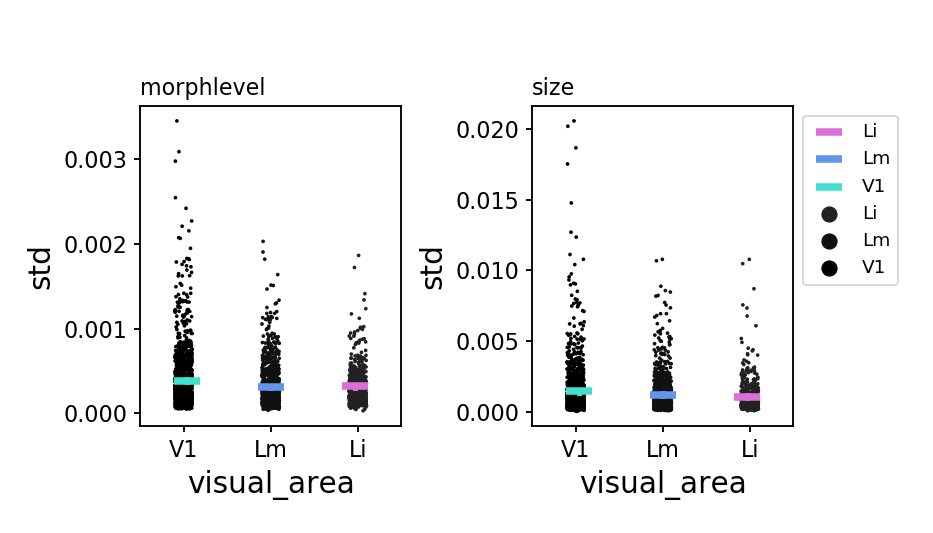

In [310]:

fig, axn = pl.subplots(1,2, figsize=(7,4))
    
for ai, (ax, (cond, mg)) in enumerate(zip(axn.flat, df.groupby(['condition']))):
    
    sns.pointplot(x='visual_area', y='std', data=mg, ax=ax, 
             hue='visual_area', palette=area_colors, order=visual_areas, scale=2,
                  markers='_', dodge=True, join=False)
    
    sns.stripplot(x='visual_area', y='std', data=mg, ax=ax, 
             hue='visual_area', color='k', order=visual_areas, size=2, zorder=-1)

    if ai==0:
        ax.legend_.remove()
    else:
        ax.legend(bbox_to_anchor=(1., 1), loc='upper left')
    ax.set_title(cond, loc='left')

pl.subplots_adjust(left=0.15, right=0.85, bottom=0.2, top=0.8, wspace=0.5)

In [311]:
melted.head()

,config,trial,cell,dff
0,config001,32,174,3.874082
1,config001,47,174,2.899157
2,config001,110,174,3.205676
3,config001,144,174,1.770535
4,config001,223,174,1.984525


## means by fov

<IPython.core.display.Javascript object>


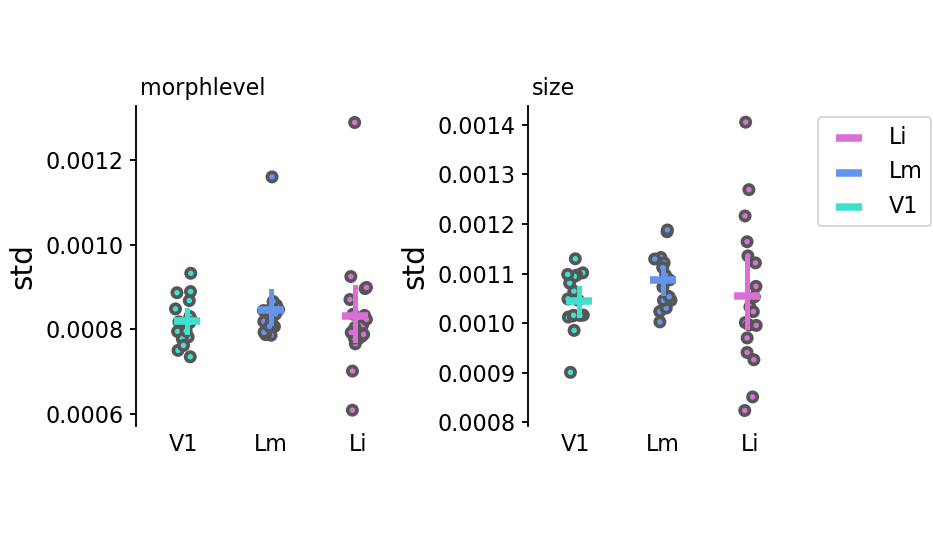

********* [std] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.313 (fdr_bh), reject H0=False
[('V1', 'Li')] p=0.479 (fdr_bh), reject H0=False
[('Lm', 'Li')] p=0.313 (fdr_bh), reject H0=False
****************************
********* [std] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.121 (fdr_bh), reject H0=False
[('V1', 'Li')] p=0.411 (fdr_bh), reject H0=False
[('Lm', 'Li')] p=0.121 (fdr_bh), reject H0=False
****************************


In [319]:
multi_comp_test='fdr_bh'

means_by_fov = df.groupby(['visual_area', 'datakey', 'condition' ]).mean().reset_index()

fig, axn = pl.subplots(1,2, figsize=(7,4))
for ai, (ax, (cond, mg)) in enumerate(zip(axn.flat, means_by_fov.groupby(['condition']))):
    
    sns.pointplot(x='visual_area', y='std', data=mg[mg.condition==cond], ax=ax, 
             hue='visual_area', palette=area_colors, order=visual_areas, scale=2,
                  markers='_', dodge=True, join=False)
    sns.stripplot(x='visual_area', y='std', data=mg[mg.condition==cond], ax=ax, 
             hue='visual_area', palette=area_colors, order=visual_areas, size=5, zorder=-1,
                 marker='o', linewidth=2) #, edgecolor=area_colors)
    
    yloc = 0.005 if cond=='size' else 0.001
    offset=0.001 if cond=='size' else 0.001
    statresults, ax = aggr.plot_mannwhitney(mg, metric='std', multi_comp_test=multi_comp_test,
                        ax=ax, y_loc=yloc, offset=offset)

    if ai==0:
        ax.legend_.remove()
    else:
        ax.legend(bbox_to_anchor=(1., 1), loc='upper left')
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')
    ax.set_title(cond, loc='left')

aggr.crop_legend_labels(axn[-1], n_hues=3)

sns.despine(offset=2, bottom=True)
pl.subplots_adjust(left=0.15, right=0.85, bottom=0.2, top=0.8, wspace=0.5)

In [163]:
sz_df

,10.0,20.0,30.0,40.0,50.0
cell,,,,,
4,0.094116,0.018369,-0.008733,0.082674,0.149786
5,0.233096,0.682982,0.355833,0.305655,0.182584
6,-0.179547,-0.131600,-0.185578,-0.264171,-0.287733
11,-0.087088,0.497692,0.405343,0.232945,0.004884
12,-0.132480,-0.217202,-0.232267,-0.223750,-0.269533
24,-0.277637,0.007466,0.008658,-0.155453,-0.227467
33,-0.132329,-0.048930,-0.066121,-0.142573,-0.274953
38,-0.184715,-0.059707,-0.181414,-0.238363,-0.319117
46,-0.033121,0.086448,0.100412,-0.032527,-0.161588


# size

In [196]:
visual_area = 'V1'
datakey = '20191006_JC110_fov1'

ndf = NDATA[(NDATA.visual_area==visual_area) & (NDATA.datakey==datakey)].copy()
sdf = SDF[dk].copy() #aggr.get_master_sdf()

ndf.head()


,visual_area,datakey,config,trial,cell,response
0,V1,20191006_JC110_fov1,config012,1,4,0.112154
1,V1,20191006_JC110_fov1,config041,2,4,1.382167
2,V1,20191006_JC110_fov1,config024,3,4,0.618503
3,V1,20191006_JC110_fov1,config016,4,4,1.325738
4,V1,20191006_JC110_fov1,config049,5,4,0.590036


In [197]:

ndf['response']  = ndf['response'].subtract(ndf['response'].min())
ndf['response'].min()

0.0

<IPython.core.display.Javascript object>


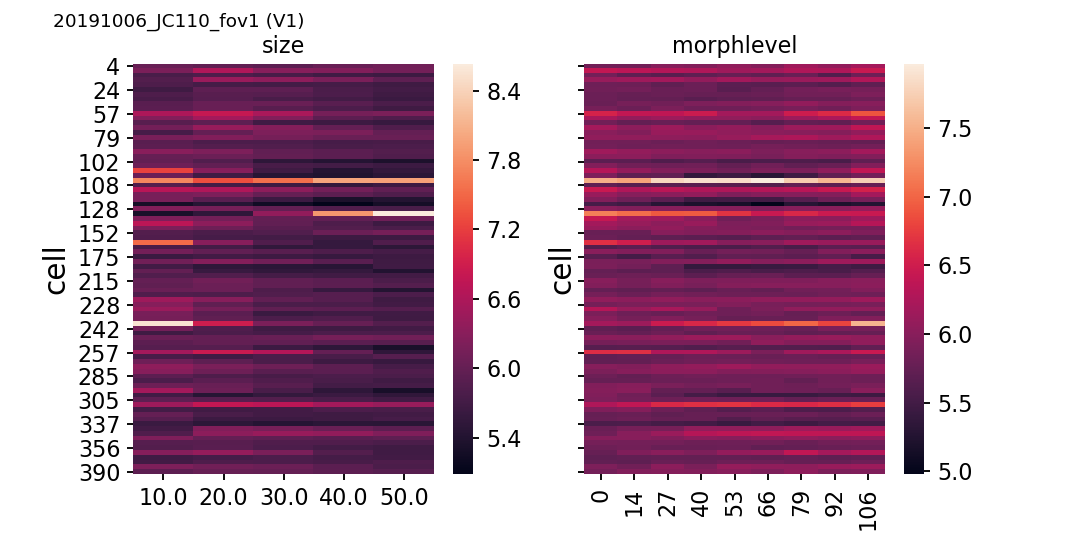

Text(0.05,0.95,u'20191006_JC110_fov1 (V1)')

In [198]:
sz_df = pd.concat([pd.Series(ndf[ndf.config.isin(sg.index.tolist())].groupby(['cell']).mean()['response'], name=sz)\
            for sz, sg in sdf[sdf.morphlevel!=-1].groupby(['size'])], axis=1)

mp_df = pd.concat([pd.Series(ndf[ndf.config.isin(sg.index.tolist())].groupby(['cell']).mean()['response'], name=sz)\
            for sz, sg in sdf[sdf.morphlevel!=-1].groupby(['morphlevel'])], axis=1)

fig, axn = pl.subplots(1,2, figsize=(8,4), sharey=True)
sns.heatmap(sz_df, ax=axn[0])
axn[0].set_title('size')

sns.heatmap(mp_df, ax=axn[1])
axn[1].set_title('morphlevel')

fig.text(0.05, 0.95, '%s (%s)' % (datakey, visual_area))

In [199]:
sz1 = sz_df.divide(sz_df.sum(axis=1), axis=0)
mp1 = mp_df.divide(mp_df.sum(axis=1), axis=0)

<IPython.core.display.Javascript object>


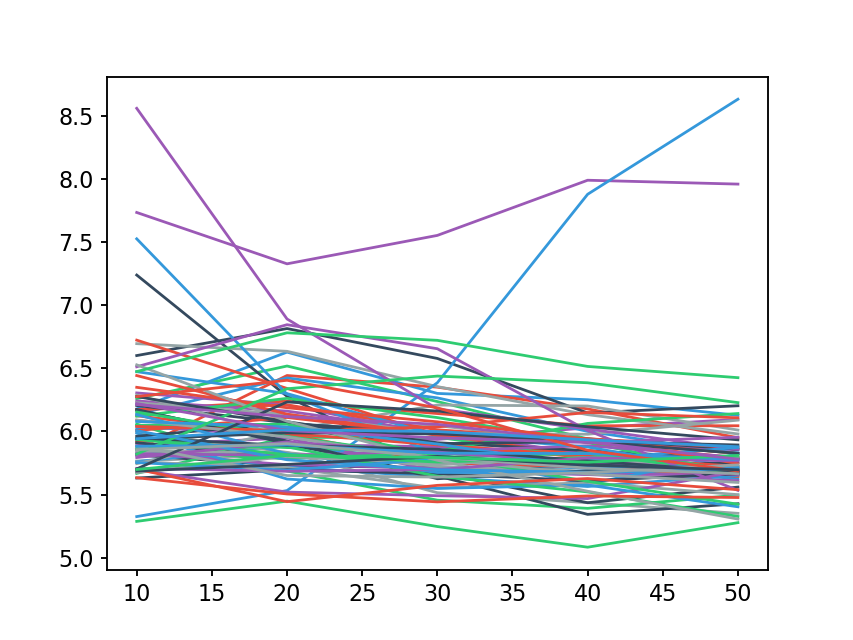

In [200]:
fig, ax = pl.subplots()
ax.plot(sz_df.T)

<IPython.core.display.Javascript object>


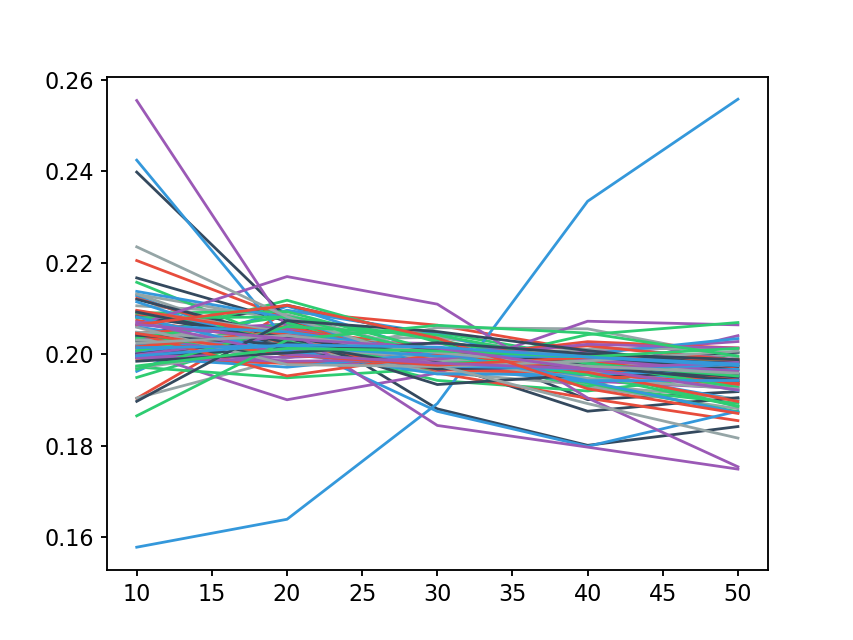

In [201]:
fig, ax = pl.subplots()
ax.plot(sz1.T)

In [162]:
sz_df.max(axis=0)

10.0    2.614566
20.0    1.382556
30.0    1.607719
40.0    2.044828
50.0    2.686854
dtype: float64

In [202]:
cell_ix, cond_val = np.where(sz1==sz1.max(axis=0))
print(sz1.iloc[cell_ix])

          10.0      20.0      30.0      40.0      50.0
cell                                                  
131   0.157771  0.163879  0.189188  0.233423  0.255738
131   0.157771  0.163879  0.189188  0.233423  0.255738
240   0.255455  0.205652  0.184395  0.179652  0.174847
257   0.206385  0.216952  0.210920  0.190391  0.175351
257   0.206385  0.216952  0.210920  0.190391  0.175351


In [203]:
cell_ix, cond_val = np.where(mp1==mp1.max(axis=0))
print(mp1.iloc[cell_ix])

           0         14        27        40        53        66        79   \
cell                                                                         
107   0.107954  0.106734  0.112266  0.113480  0.113141  0.114787  0.111238   
131   0.118044  0.115979  0.114019  0.114214  0.110182  0.106297  0.108548   
131   0.118044  0.115979  0.114019  0.114214  0.110182  0.106297  0.108548   
167   0.119258  0.116423  0.110038  0.110422  0.107034  0.107488  0.110343   
178   0.109087  0.108837  0.110158  0.110372  0.112031  0.110662  0.111447   
240   0.102764  0.101787  0.107381  0.109229  0.111526  0.113447  0.116136   
257   0.117042  0.117446  0.110464  0.110682  0.108011  0.104230  0.108509   
353   0.103630  0.106704  0.109133  0.112366  0.113410  0.113912  0.113637   
364   0.105384  0.108477  0.109888  0.108400  0.111033  0.111825  0.116805   

           92        106  
cell                      
107   0.108737  0.111662  
131   0.106545  0.106172  
131   0.106545  0.106172  
167   

## Check values

In [160]:
cell_ix, cond_val = np.where(sz_df==sz_df.max(axis=0))
print(sz_df.iloc[cell_ix])

          10.0      20.0      30.0      40.0      50.0
cell                                                  
107   1.789416  1.382556  1.607719  2.044828  2.014223
107   1.789416  1.382556  1.607719  2.044828  2.014223
107   1.789416  1.382556  1.607719  2.044828  2.014223
131  -0.620056 -0.413879  0.440439  1.933593  2.686854
240   2.614566  0.945665  0.233360  0.074407 -0.086597


In [71]:
cell_ix, cond_val = np.where(mp_df==mp_df.max(axis=0))
print(mp_df.iloc[cell_ix])

           0         14        27        40        53      66        79   \
cell                                                                       
107   1.549039  1.464329  1.848421  1.932673  1.909129  2.0234  1.777028   
107   1.549039  1.464329  1.848421  1.932673  1.909129  2.0234  1.777028   
107   1.549039  1.464329  1.848421  1.932673  1.909129  2.0234  1.777028   
107   1.549039  1.464329  1.848421  1.932673  1.909129  2.0234  1.777028   
107   1.549039  1.464329  1.848421  1.932673  1.909129  2.0234  1.777028   
107   1.549039  1.464329  1.848421  1.932673  1.909129  2.0234  1.777028   
107   1.549039  1.464329  1.848421  1.932673  1.909129  2.0234  1.777028   
107   1.549039  1.464329  1.848421  1.932673  1.909129  2.0234  1.777028   
107   1.549039  1.464329  1.848421  1.932673  1.909129  2.0234  1.777028   

           92        106  
cell                      
107   1.603401  1.806487  
107   1.603401  1.806487  
107   1.603401  1.806487  
107   1.603401  1.806487  
1

<IPython.core.display.Javascript object>


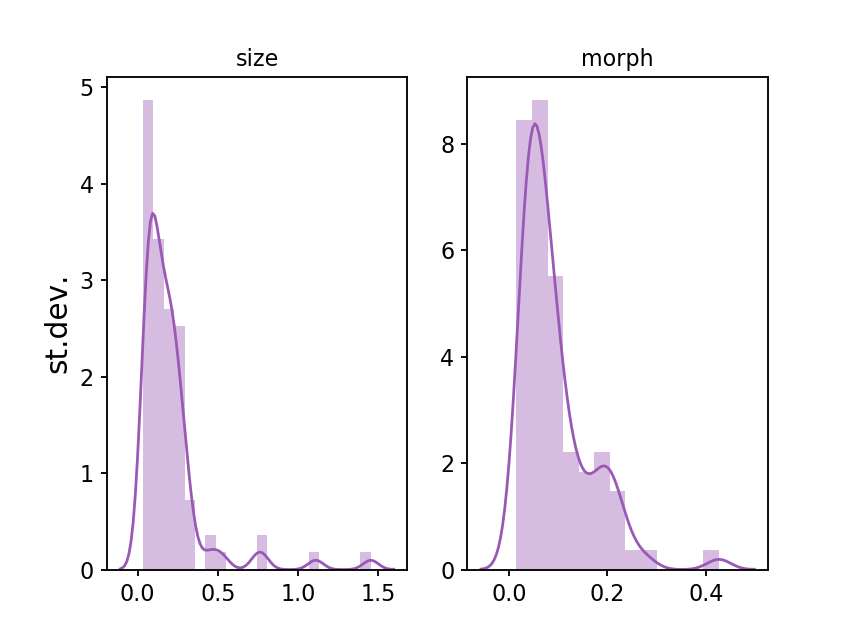

Text(0.5,1,u'morph')

In [204]:
std_sz = sz_df.std(axis=1)
std_mp = mp_df.std(axis=1)
fig, axn = pl.subplots(1,2)
sns.distplot(std_sz, ax=axn[0])
axn[0].set_title('size')
axn[0].set_ylabel('st.dev.')

sns.distplot(std_mp, ax=axn[1])
axn[1].set_title('morph')

In [210]:
std_sz.sort_values(ascending=False)[0:5]

cell
131    1.454686
240    1.111073
167    0.780192
104    0.745709
257    0.534411
dtype: float64

In [211]:
std_mp.sort_values(ascending=False)[0:5]

cell
240    0.426970
131    0.276484
257    0.243613
167    0.226874
106    0.219873
dtype: float64

<IPython.core.display.Javascript object>


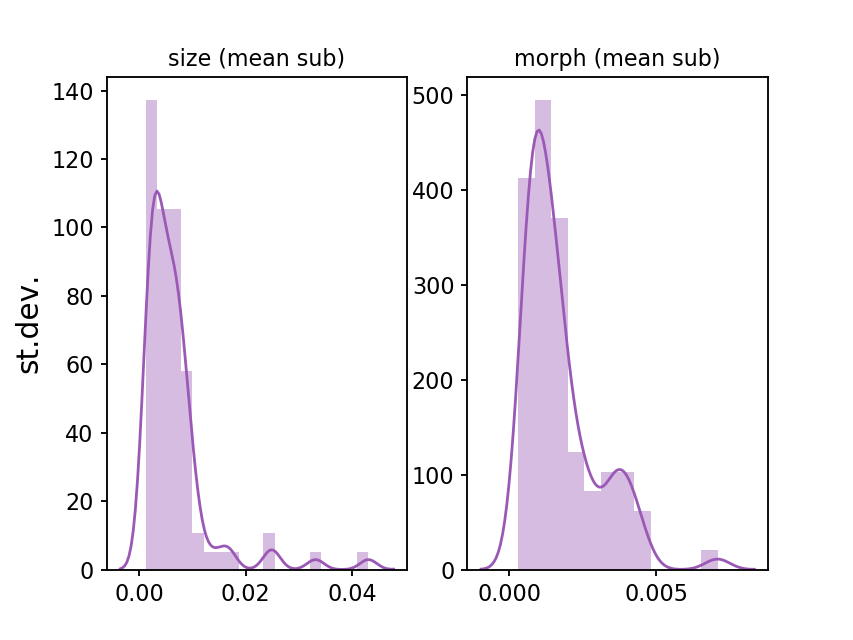

Text(0.5,1,u'morph (mean sub)')

In [212]:
std_sz1 = sz1.std(axis=1)
std_mp1 = mp1.std(axis=1)
fig, axn = pl.subplots(1,2)
sns.distplot(std_sz1, ax=axn[0])
axn[0].set_title('size (mean sub)')
axn[0].set_ylabel('st.dev.')

sns.distplot(std_mp1, ax=axn[1])
axn[1].set_title('morph (mean sub)')

In [213]:
std_sz1.sort_values(ascending=False)[0:5]

cell
131    0.043095
240    0.033157
167    0.025129
104    0.024701
257    0.016936
dtype: float64

In [214]:
std_mp1.sort_values(ascending=False)[0:5]


cell
240    0.007076
131    0.004551
106    0.004349
257    0.004290
182    0.004068
dtype: float64

In [66]:
sz_normed = sz_df.divide(sz_df.sum(axis=1), axis=0)
mp_normed = mp_df.divide(mp_df.sum(axis=1), axis=0)

<IPython.core.display.Javascript object>


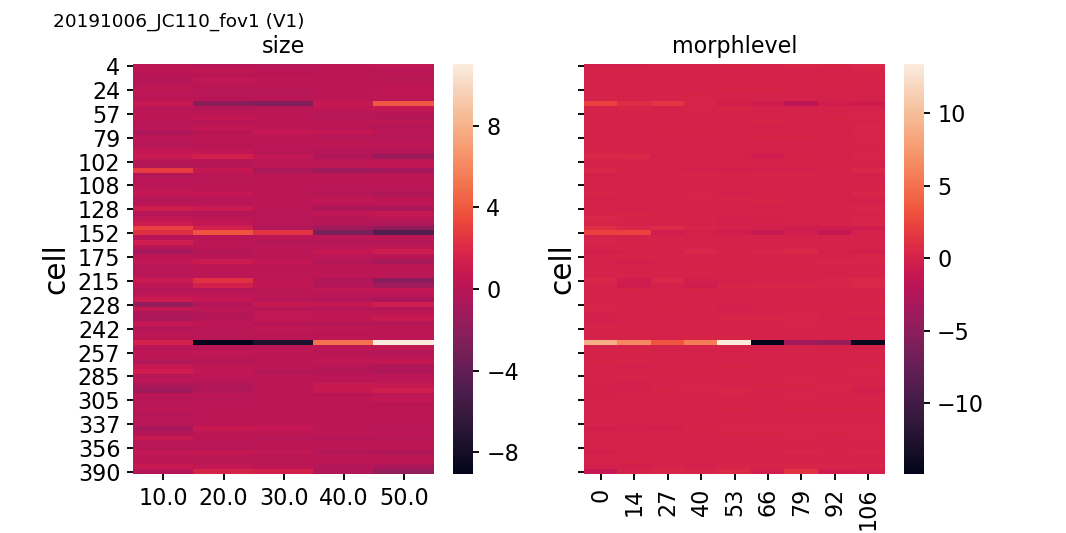

Text(0.05,0.95,u'20191006_JC110_fov1 (V1)')

In [72]:
fig, axn = pl.subplots(1,2, figsize=(8,4), sharey=True)
sns.heatmap(sz_normed, ax=axn[0])
axn[0].set_title('size')

sns.heatmap(mp_normed, ax=axn[1])
axn[1].set_title('morphlevel')

fig.text(0.05, 0.95, '%s (%s)' % (datakey, visual_area))

In [68]:
sz_normed

,10.0,20.0,30.0,40.0,50.0
cell,,,,,
4,0.279930,0.054635,-0.025974,0.245898,0.445511
5,0.132429,0.388025,0.202161,0.173653,0.103732
6,0.171221,0.125497,0.176972,0.251920,0.274390
11,-0.082643,0.472294,0.384657,0.221057,0.004634
12,0.123210,0.202005,0.216016,0.208095,0.250674
24,0.430824,-0.011586,-0.013435,0.241225,0.352972
33,0.199019,0.073590,0.099444,0.214426,0.413521
38,0.187849,0.060720,0.184492,0.242407,0.324532
46,0.820320,-2.141120,-2.486971,0.805615,4.002157


In [69]:
sz_df.loc[104]

10.0    1.293711
20.0    0.333060
30.0   -0.269580
40.0   -0.510206
50.0   -0.386244
Name: 104, dtype: float64

In [ ]:
filter_by='most_fits'
blob_dsets = aggr.get_blob_datasets(filter_by=filter_by, as_dict=False, response_type=response_type,
                                    responsive_test=responsive_test, responsive_thr=responsive_thr)

all_dkeys = sdata[(sdata['experiment']==experiment)]['datakey'].unique()
unique_dkeys = blob_dsets['datakey'].unique()

n_drop = len(all_dkeys) - len(unique_dkeys)
print("Dropping %i dkeys (%i of %i dkeys unique)" % (n_drop, len(unique_dkeys), len(all_dkeys)))